# Image Restoration

This notebook aims to build a model of restoring autoencoder for MNIST.

----------------------

Input: Input data is an MNIST image corrupted by a white square of at most 25% of the image area

Output: Restored MNIST image w/o the corrupting white square.

----------------------

Notes:

1. Area of white square follows a uniform distribution over [6.25, 25] percent of the image area. That is, the dimension of the square should be sampled from: S = [7, 14] pixels.

2. Position of white square is randomly chosen. The x- and y-coordinates of the top-left corner are independently sampled from a uniform distribution over [0, 28 - S], where S is the length of the white square's side.

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.insert(1, "/content/drive/My Drive/Colab Notebooks/hw2")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import random

from benchmark_keras import test_model
from transforms import corrupt_mnist_copy
from model_keras import make_convolutional_autoencoder

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Data Loading and Preprocessing

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Split the train data into a train set and a validation set.

In [0]:
X_train, X_valid = train_test_split(X_train, test_size=500)

Corrupt MNIST image by a white square of at most 25% of the image area

In [0]:
X_train_noisy = corrupt_mnist_copy(X_train)
X_valid_noisy = corrupt_mnist_copy(X_valid)
X_test_noisy  = corrupt_mnist_copy(X_test)

Normalized image data

In [0]:
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train_noisy = X_train_noisy.astype('float32') / 255
X_valid_noisy = X_valid_noisy.astype('float32') / 255
X_test_noisy = X_test_noisy.astype('float32') / 255

## Convolutional Autoencoder

Create a convolutional autoencoder with the following architecture. Binary cross entropy was used for training the model.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


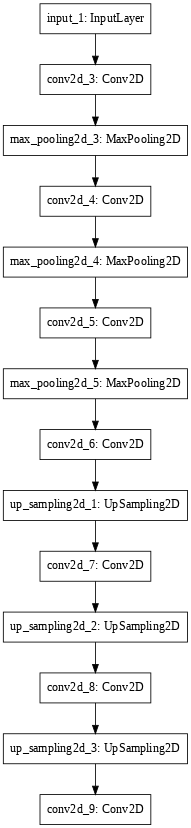

In [8]:
autoencoder = make_convolutional_autoencoder()
plot_model(autoencoder, dpi=60)

Reshape the image data to the format the autoencoder expects for training.

In [0]:
# reshape the flattened images to 28x28 with 1 channel
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)
X_train_noisy = X_train_noisy.reshape(-1, 28, 28, 1)
X_valid_noisy = X_valid_noisy.reshape(-1, 28, 28, 1)
X_test_noisy  = X_test_noisy.reshape(-1, 28, 28, 1)

Train autoencoder with the corrupted data as input and the original data as expected output.

In [10]:
autoencoder = make_convolutional_autoencoder()
history = autoencoder.fit(X_train_noisy, X_train, 
                          epochs=50, 
                          batch_size=128, 
                          validation_data=(X_valid_noisy, X_valid),
                          verbose=0)

### Model loss

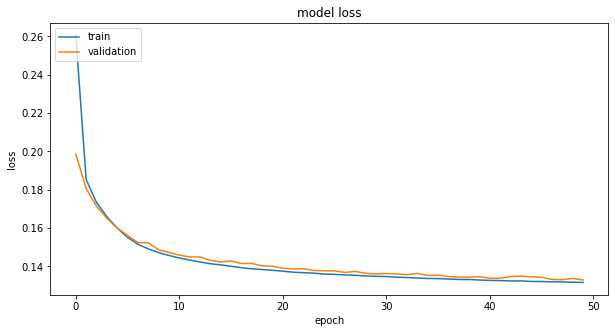

In [15]:
fig = plt.figure(figsize=(10,5))
# loss
ax1 = fig.add_subplot(111)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
plt.show()

### Restore corrupted test images using the trained autoencoder.

In [0]:
X_test_decoded = autoencoder.predict(X_test_noisy)

The following shows that most images are restored except for the images where almost half of the digit was covered which would be hard to classify even for the human eye.

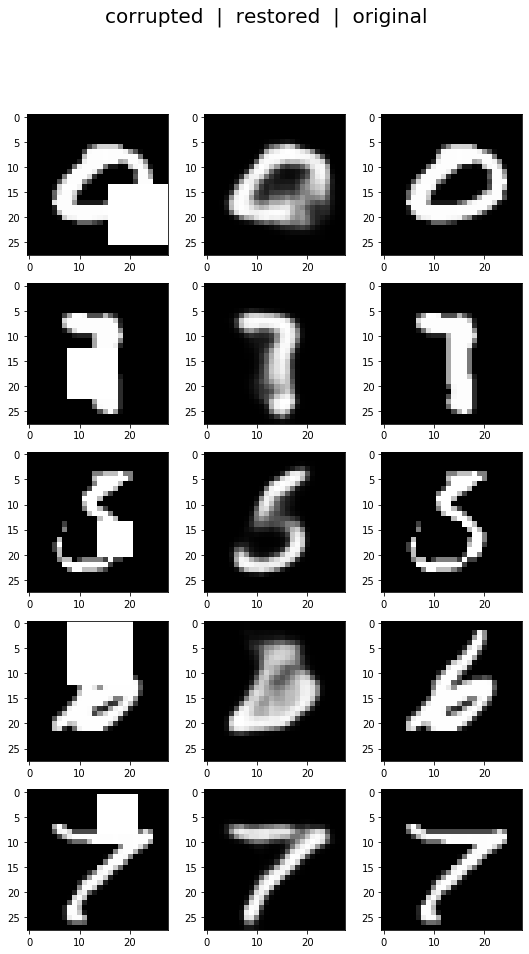

In [17]:
with_noise = sorted(set(np.floor(np.where(~(X_test == X_test_noisy).flatten())[0]/(28*28)).astype(np.int16)))
random.shuffle(with_noise)
plt.figure(figsize=(9,15))
plt.suptitle('corrupted  |  restored  |  original', fontsize=20)

for index in range(5):
    id = with_noise[index]
    # corrupted
    ax1 = plt.subplot2grid((5,3), (index,0))
    ax1.imshow(X_test_noisy[id].reshape((28, 28)), cmap='gray')
    # restored
    ax2 = plt.subplot2grid((5,3), (index,1))
    ax2.imshow(X_test_decoded[id].reshape((28, 28)), cmap='gray')
    # original
    ax3 = plt.subplot2grid((5,3), (index,2))
    ax3.imshow(X_test[id].reshape((28, 28)), cmap='gray')

The following scores are comparable to the following baseline: 

- Classifier: 78.36
- SSIM: 75

In [18]:
test_model(autoencoder, X_test.reshape(-1, 28, 28), y_test, batch_size=100)

Classifier score: 86.22
SSIM score: 87.21


Comparable training and validation loss showed that the model did not overfit. Benchmark scores showed that the model did not underfit either.